In [ ]:
import torch
import numpy as np

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred - y_true) ** 2
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

    def backward(self):
        # dvalue - значение производной, которое приходит нейрону от следующего слоя сети
        # в данном случае это будет значение df/dc (созданное методом backwards у объекта MSELoss) - по сути производная ошибки dE
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
torch.randn(6, requires_grad=True), torch.randn(1, requires_grad=True)

(tensor([ 0.9390,  0.4504,  0.7793,  0.2364, -0.9653,  0.5416],
        requires_grad=True),
 tensor([0.1241], requires_grad=True))

In [ ]:
import random

n_inputs = X.shape[-1] # <размерность элемента выборки >
lr = 0.002 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)

loss = SquaredLoss()


for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):

#         print(x_example, y_example)
#         break
        y_pred = neuron.forward(x_example) # <прогон через нейрон>

        loss.forward(y_pred, y_example) # <прогон через функцию потерь>

        losses.append(loss.loss.item())

        # backprop
        loss.backward()

        neuron.backward()

        # градиентный спуск

        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.dbias



        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

    if epoch%10==0:
        print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')
    # <вызов методов backward>
    # обратите внимание на последовательность вызовов: от конца к началу
#     break
    # <шаг оптимизации для весов (weights и bias) нейрона>

epoch 0 mean loss 1120.6143638384342
epoch 10 mean loss 0.037631105498096534
epoch 20 mean loss 1.1330397527444802e-05
epoch 30 mean loss 9.877782085609965e-09
epoch 40 mean loss 9.818683111006976e-10
epoch 50 mean loss 9.713871751415581e-10
epoch 60 mean loss 9.693484148698417e-10
epoch 70 mean loss 9.693484148698417e-10
epoch 80 mean loss 9.693484148698417e-10
epoch 90 mean loss 9.693484148698417e-10


3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
y[:10]

tensor([[0.0948],
        [0.1069],
        [0.2206],
        [0.2510],
        [0.3188],
        [0.3522],
        [0.4534],
        [0.5093],
        [0.5167],
        [0.5825]])

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 5)
relu1 = ReLU()
fc2 = Linear(5, 1)
loss = MSELoss()

lr = 0.01

ys = []
losses = []
for epoch in range(11):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 2 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    fc2.backward()
    fc1.backward()

    # <шаг оптимизации для fc1>
    with torch.no_grad():
        fc1.weights -= lr * fc1.dweights
        fc1.bias -= lr * fc1.dbias

    # <шаг оптимизации для fc2>
    with torch.no_grad():
        fc2.weights -= lr * fc2.dweights
        fc2.bias -= lr * fc2.dbias

    # <обнуляем градиент для fc1>
    fc1.weights.grad.zero_()
    fc1.bias.grad.zero_()

    # <обнуляем градиент для fc2>
    fc2.weights.grad.zero_()
    fc2.bias.grad.zero_()

epoch 0 mean loss 0.8896825909614563
epoch 2 mean loss 0.7274242639541626
epoch 4 mean loss 0.6703624129295349
epoch 6 mean loss 0.6474389433860779
epoch 8 mean loss 0.6355845928192139
epoch 10 mean loss 0.6273568868637085


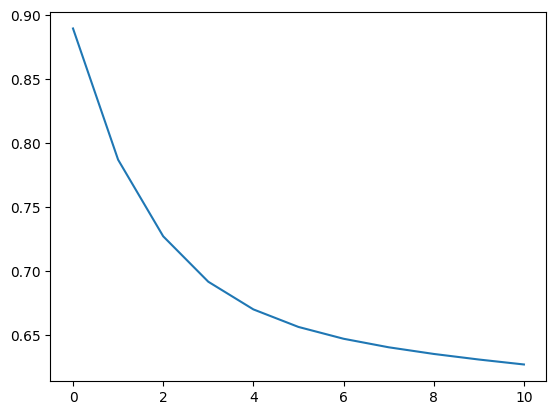

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

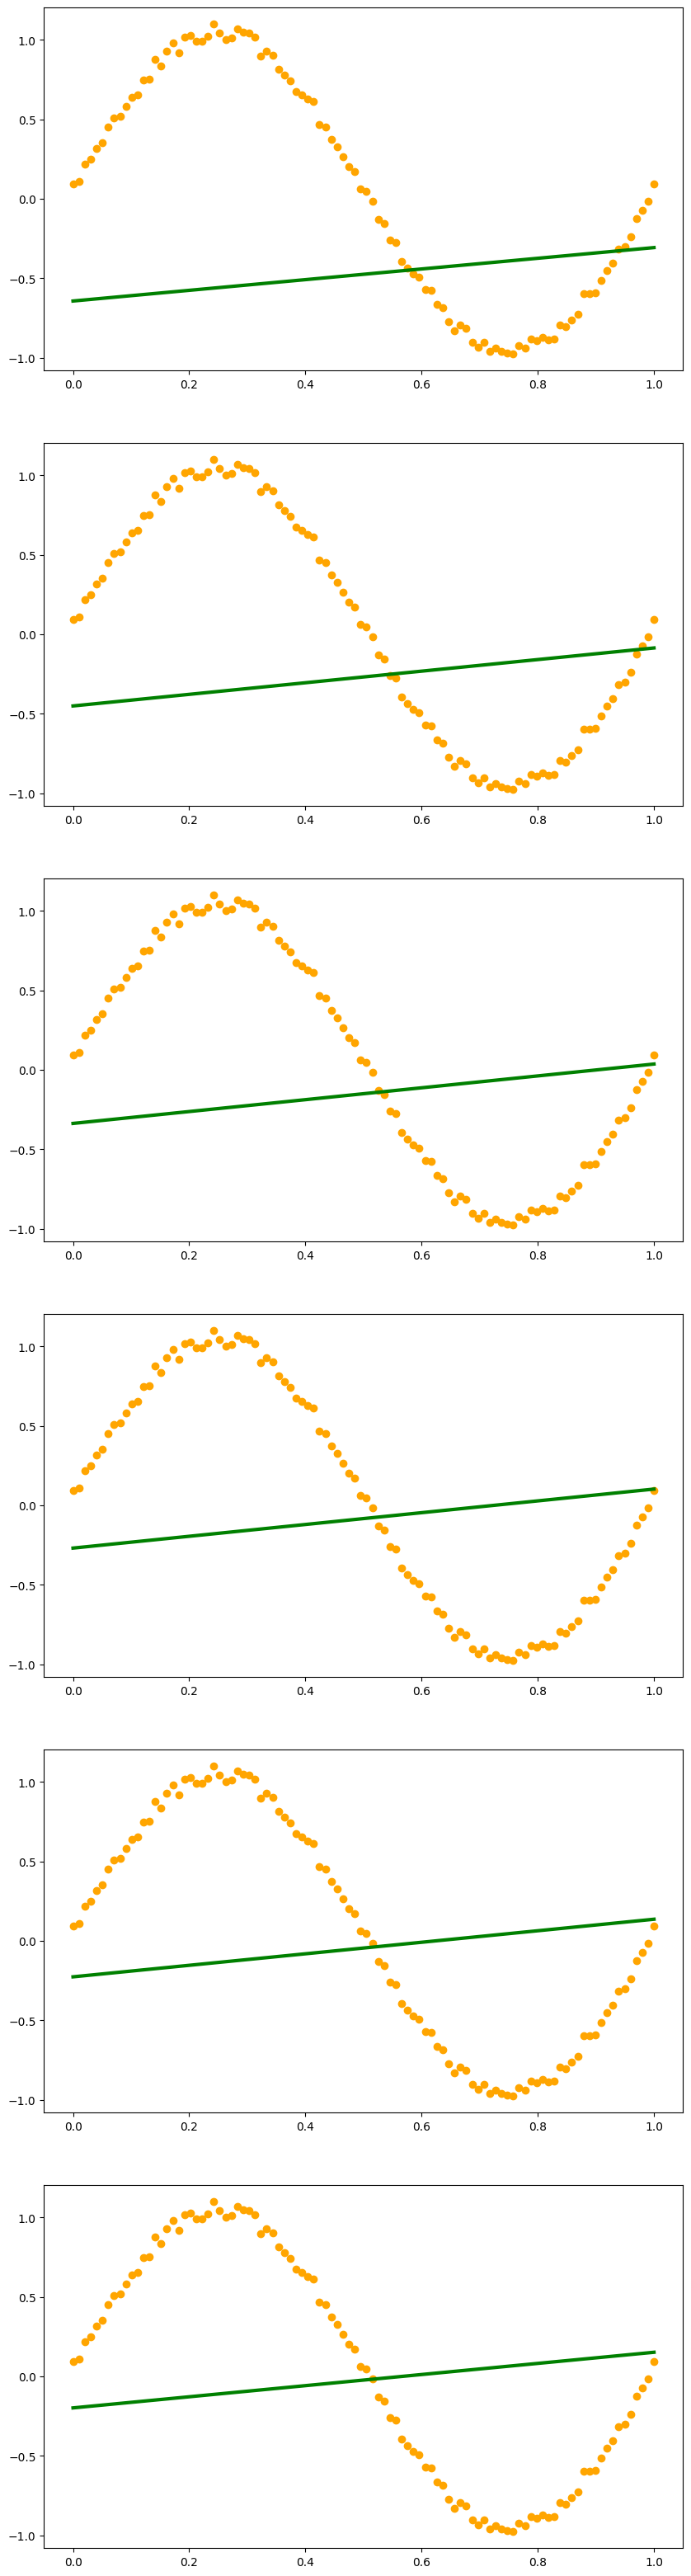

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
    ax.scatter(X.numpy(), y.numpy(), color = "orange")
    ax.plot(X.numpy(), y_.detach().numpy(), 'g-', lw=3)

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred - y_true) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

In [ ]:
import random

n_inputs = 4 # <размерность элемента выборки >
lr = 0.01 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)
loss = SquaredLoss()

optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=lr)

for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):
        # forward pass

        y_pred = neuron.forward(x_example) # <прогон через нейрон>
        curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
        losses.append(curr_loss)

        # backprop
        loss.backward()

        #optimizer
        optimizer.step()
        optimizer.zero_grad()



    if epoch%10==0:
        print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')
    # <вызов методов backward>
    # обратите внимание на последовательность вызовов: от конца к началу

    # <шаг оптимизации для весов (weights и bias) нейрона>

epoch 0 mean loss 2338.197998046875
epoch 10 mean loss 1.911270031129675e-09
epoch 20 mean loss 9.841270021127002e-10
epoch 30 mean loss 9.841270021127002e-10
epoch 40 mean loss 9.841270021127002e-10
epoch 50 mean loss 9.841270021127002e-10
epoch 60 mean loss 9.841270021127002e-10
epoch 70 mean loss 9.841270021127002e-10
epoch 80 mean loss 9.841270021127002e-10
epoch 90 mean loss 9.841270021127002e-10


3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 10)
relu1 = ReLU()
fc2 = Linear(10, 1)

loss = MSELoss()
lr = 0.01

optimizer = torch.optim.Adam([fc1.weights, fc1.bias, fc2.weights, fc2.bias], lr=lr)

ys = []
losses = []
for epoch in range(1001):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 200 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch 0 mean loss 12.967885971069336
epoch 200 mean loss 0.16949737071990967
epoch 400 mean loss 0.15967030823230743
epoch 600 mean loss 0.15643064677715302
epoch 800 mean loss 0.15388332307338715
epoch 1000 mean loss 0.15145930647850037


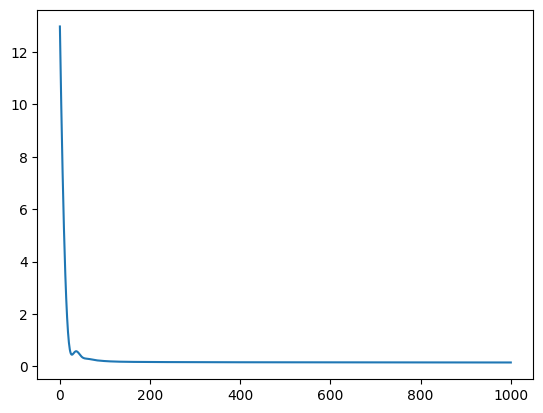

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

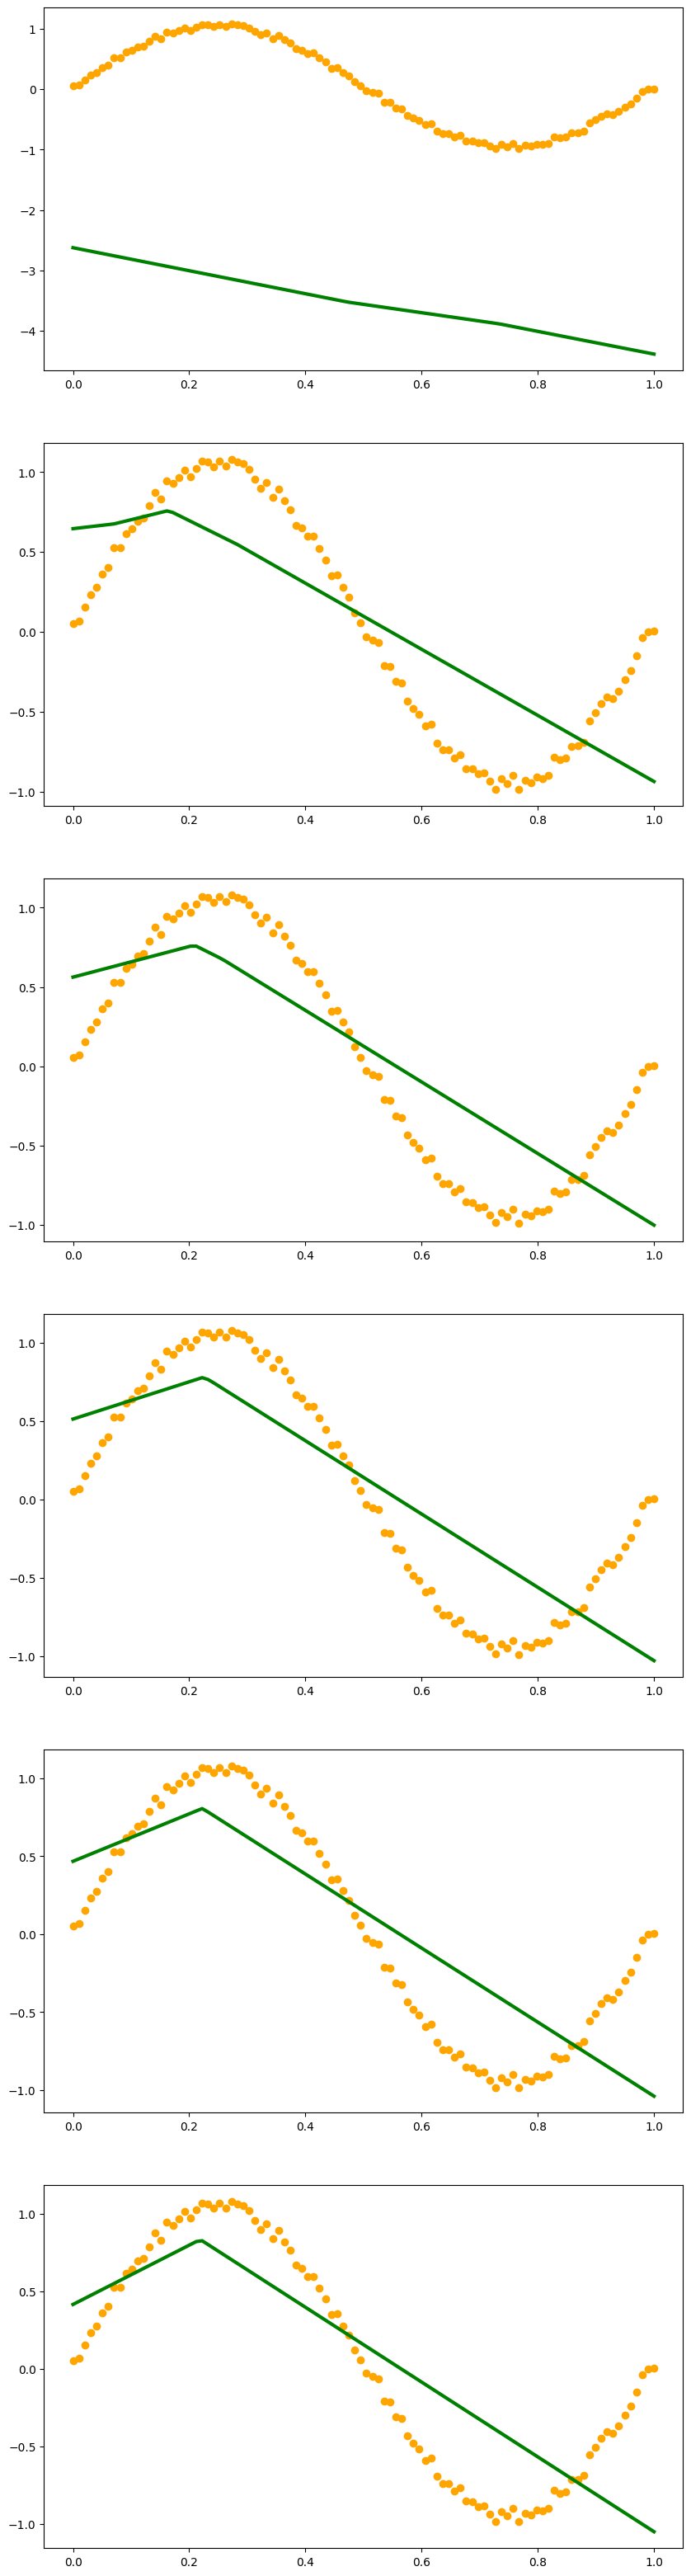

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
    ax.scatter(X.numpy(), y.numpy(), color = "orange")
    ax.plot(X.numpy(), y_.detach().numpy(), 'g-', lw=3)

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn
import torch
import numpy as np

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden_neurons)

        # поэкспериментировать с другиями функциями активации

        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50)

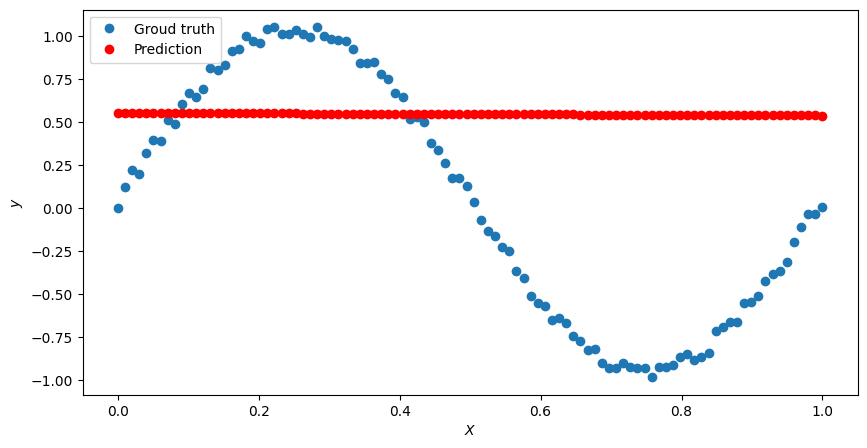

In [ ]:
import matplotlib.pyplot as plt

def predict(net, X, y):
        y_pred = net.forward(X)

        plt.figure(figsize=(10, 5))
        plt.plot(X.numpy(), y.numpy(), 'o', label='Groud truth')
        plt.plot(X.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
        plt.legend(loc='upper left')
        plt.xlabel('$X$')
        plt.ylabel('$y$')

predict(sine_net, X, y)

In [ ]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

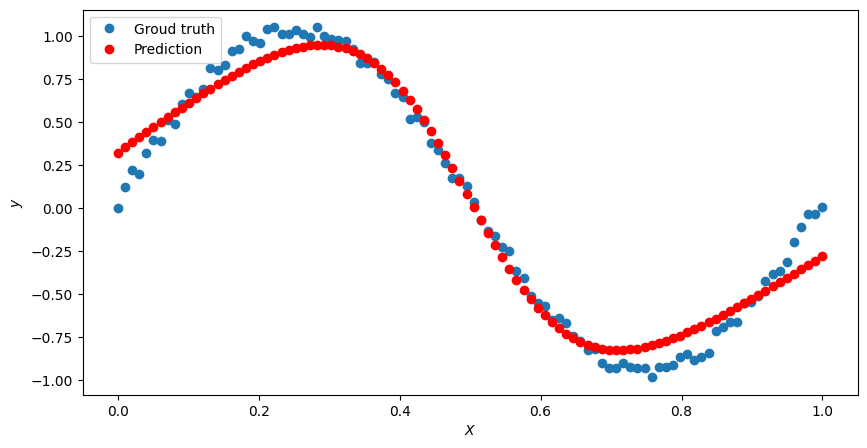

In [ ]:
for epoch_index in range(1001):
    optimizer.zero_grad()

    y_pred = sine_net.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(sine_net, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

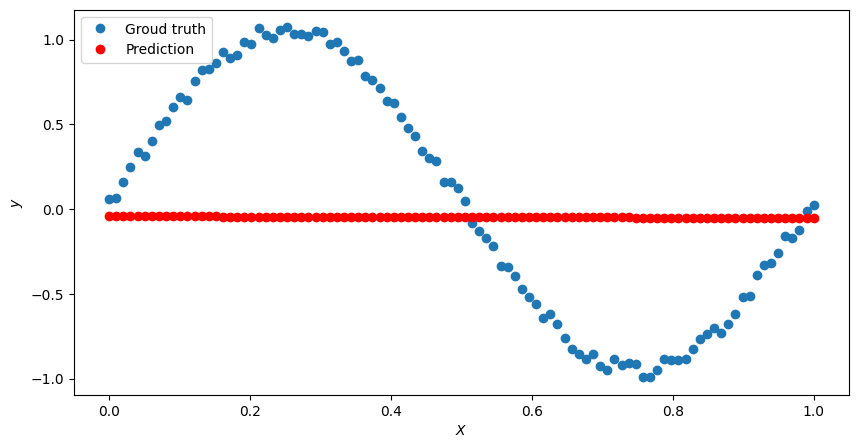

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
predict(model, X, y)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

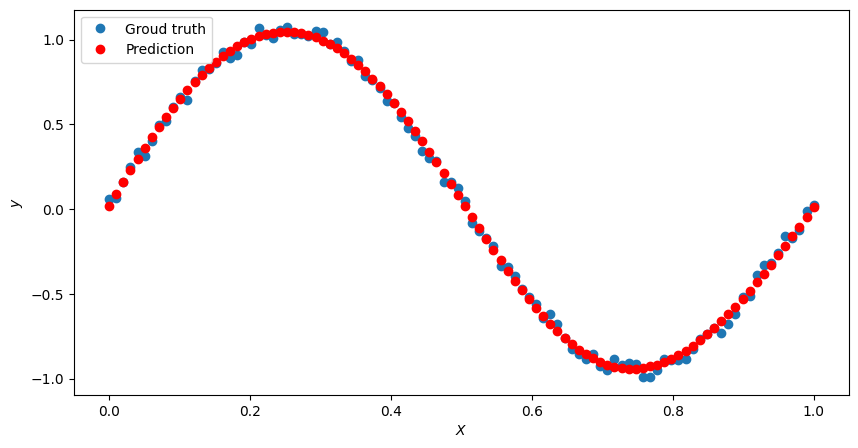

In [ ]:
for epoch_index in range(3000):
    optimizer.zero_grad()

    y_pred = model.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(model, X, y)

## 3.4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
    def __init__(self):
        self.n_samples = X.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

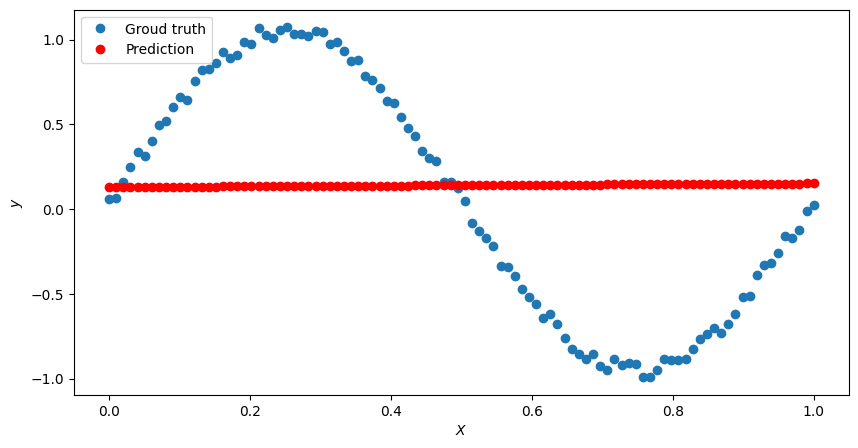

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
dataset = SinDataset()
dataloader = DataLoader(dataset, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')
predict(model, X, y)

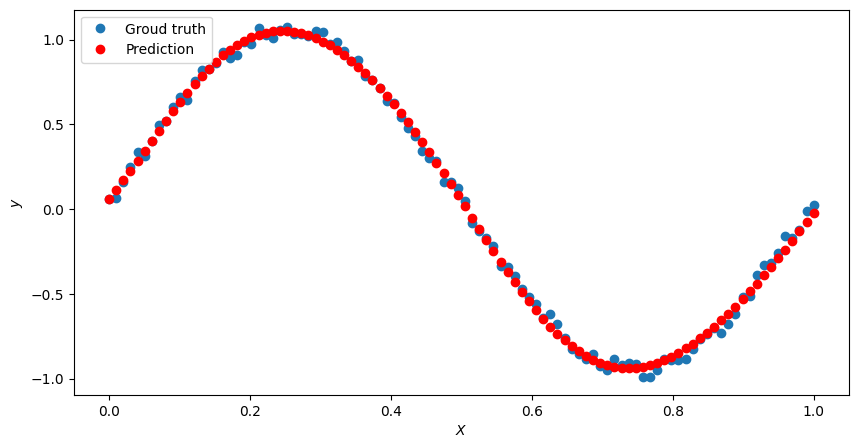

In [ ]:
for epoch_index in range(3000):
    for x_example, y_example in dataloader:
        optimizer.zero_grad()

        y_pred = model.forward(x_example)
        loss_val = criterion.forward(y_pred, y_example)

        loss_val.backward()

        optimizer.step()

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.

In [ ]:
import pandas as pd

diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
diamonds.select_dtypes(exclude='object')

,carat,depth,table,price,x,y,z
1,0.23,61.5,55.0,326,3.95,3.98,2.43
2,0.21,59.8,61.0,326,3.89,3.84,2.31
3,0.23,56.9,65.0,327,4.05,4.07,2.31
4,0.29,62.4,58.0,334,4.20,4.23,2.63
5,0.31,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53936,0.72,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        data = data.select_dtypes(exclude='object')
        self.data_x = torch.from_numpy(data.drop("price", axis=1).values).float()
        self.data_y = torch.from_numpy(data[["price"]].values).float()
        self.n_samples = self.data_x.shape[0]


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [ ]:
dataset = DiamondsDataset(diamonds)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(dataset.data_x.shape[-1]),
    nn.Linear(dataset.data_x.shape[-1], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

epoch 0 loss 2099501184.0
epoch 25 loss 554907392.0
epoch 50 loss 538620672.0
epoch 75 loss 524378368.0
epoch 100 loss 516129440.0


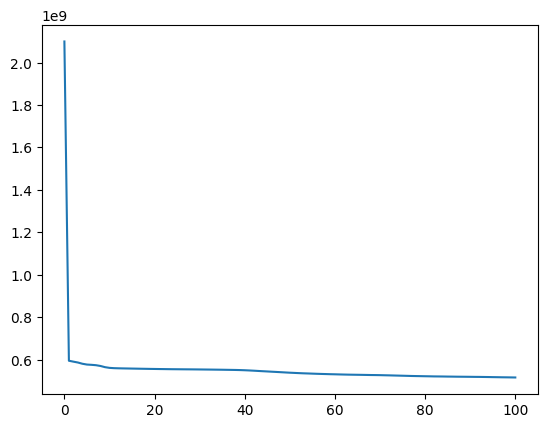

In [ ]:
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

463978976.0


In [ ]:
dataset.__getitem__(0)

(tensor([ 0.2300, 61.5000, 55.0000,  3.9500,  3.9800,  2.4300]),
 tensor([326.]))

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.n_samples = data.shape[0]
        self.transform = transform
        self.x_data = data.drop("price", axis=1).values
        self.y_data = data[["price"]].values

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):

        sample = self.x_data[idx], self.y_data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, sample):
        X, y = sample
        X = np.delete(X, self.drop, 0)
        return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        X = torch.from_numpy(X.astype("float")).float().view(-1)
        y = torch.from_numpy(y.astype("float")).float().view(-1)
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(diamonds, transforms.Compose([drop, to_tensor]))

In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(6),
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

epoch 0 loss 2150875136.0
epoch 25 loss 566768960.0
epoch 50 loss 563411904.0
epoch 75 loss 533535552.0
epoch 100 loss 521801376.0


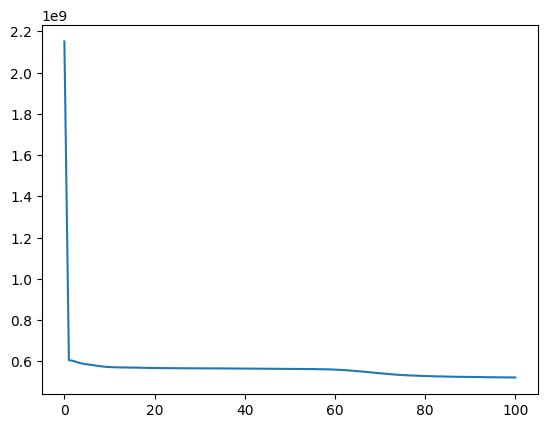

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)

    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))



    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

495436480.0


# Решение задачи 2 с датасетом сердечных заболеваний

In [ ]:
class HeartDataset(Dataset):
    def __init__(self, data):
        data = data.select_dtypes(exclude='object')
        self.data_x = torch.from_numpy(data.drop("HeartDisease", axis=1).values).float()
        self.data_y = torch.from_numpy(data[["HeartDisease"]].values).float()
        self.n_samples = self.data_x.shape[0]


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [ ]:
heart = pd.read_csv('heart.csv')
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
dataset = HeartDataset(heart)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(dataset.data_x.shape[-1]),
    nn.Linear(dataset.data_x.shape[-1], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [ ]:
losses_all = []
for epoch in range(300):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

epoch 0 loss 105.64571380615234
epoch 25 loss 33.2287712097168
epoch 50 loss 26.695016860961914
epoch 75 loss 20.193771362304688
epoch 100 loss 15.05096435546875
epoch 125 loss 12.64173412322998
epoch 150 loss 10.358247756958008
epoch 175 loss 7.78822660446167
epoch 200 loss 6.157521724700928
epoch 225 loss 5.888833522796631
epoch 250 loss 6.568840503692627
epoch 275 loss 4.394040584564209


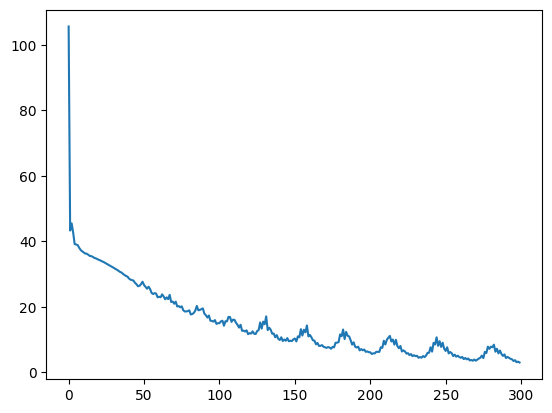

In [ ]:
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

51.94367980957031
